**Random Forest**

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ecc16e7a9e05f2891a7c89b8ac09f5635cf3e524b16c2aac03b0511d45c09da1
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import ta  # Technical Analysis Library

In [4]:
import requests
import pandas as pd

# List of cryptocurrencies
cryptos = ["bitcoin", "ethereum", "ripple"]

# Fetch data for each cryptocurrency
data = {}
for crypto in cryptos:
    print(f"Fetching data for {crypto}...")
    url = f"https://api.coingecko.com/api/v3/coins/{crypto}/market_chart?vs_currency=usd&days=365&interval=daily"
    response = requests.get(url)
    json_data = response.json()

    # Create DataFrame
    df = pd.DataFrame(json_data['prices'], columns=['timestamp', 'price'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('Date', inplace=True)
    df['Crypto'] = crypto
    df.drop(columns=['timestamp'], inplace=True)

    # Store data
    data[crypto] = df

# Combine all DataFrames into one
df_all = pd.concat(data.values())

# Display the first few rows
print(df_all.head())


Fetching data for bitcoin...
Fetching data for ethereum...
Fetching data for ripple...
                   price   Crypto
Date                             
2024-04-20  63988.818472  bitcoin
2024-04-21  64894.418691  bitcoin
2024-04-22  64936.420757  bitcoin
2024-04-23  66841.666852  bitcoin
2024-04-24  66406.952444  bitcoin


In [5]:
# Compute daily returns
df_all["Return"] = (df_all["price"].shift(-1) - df_all["price"]) / df_all["price"]

# Define return categories
def categorize_return(ret):
    if ret < -0.03:   # Very large drop
        return 0
    elif -0.03 <= ret < -0.01:  # Moderate drop
        return 1
    elif -0.01 <= ret < 0:  # Small drop
        return 2
    elif 0 <= ret < 0.01:  # Small rise
        return 3
    elif 0.01 <= ret < 0.03:  # Moderate rise
        return 4
    else:  # Very large rise
        return 5

# Apply the categorization function
df_all["ReturnCategory"] = df_all["Return"].apply(categorize_return)

# Drop NaN values
df_all.dropna(inplace=True)

In [6]:
# Ensure the DataFrame is structured as you expect, with 'Crypto', 'Close', 'High', and 'Low'

# Compute Moving Averages
df_all["SMA_10"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.trend.sma_indicator(x, window=10))
df_all["SMA_30"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.trend.sma_indicator(x, window=30))

# Relative Strength Index (RSI)
df_all["RSI"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.momentum.rsi(x, window=14))

# MACD (Moving Average Convergence Divergence)
df_all["MACD"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.trend.macd(x))

# Bollinger Bands
df_all["BB_High"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.volatility.bollinger_hband(x, window=20))
df_all["BB_Low"] = df_all.groupby("Crypto")["price"].transform(lambda x: ta.volatility.bollinger_lband(x, window=20))

# Average True Range (ATR) for volatility
df_all["ATR"] = df_all.groupby("Crypto").apply(lambda x: ta.volatility.average_true_range(x["price"], x["price"], x["price"], window=14)).reset_index(level=0, drop=True)

# Drop any remaining NaN values
df_all.dropna(inplace=True)



<ipython-input-6-ba2b85e85c06>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all["ATR"] = df_all.groupby("Crypto").apply(lambda x: ta.volatility.average_true_range(x["price"], x["price"], x["price"], window=14)).reset_index(level=0, drop=True)


Use Random Forest and XG Boost

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 808, number of used features: 7
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Random Forest Accuracy: 0.16831683168316833
XGBoost Accuracy: 0.21782178217821782
LightGBM Accuracy: 0.19306930693069307
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.17      0.16        30
           1       0.25      0.31      0.28        39
           2       0.14      0.16      0.15        31
           3       0.24      0.21      0.23        33
           4       0.21      0.20      0.20        41
           5       0.37      0.25      0.30        28

    accuracy                           0.22       202
   macro avg       0.23      0.22      0.22       202
weighted avg       0.23      0.22      0.22       202



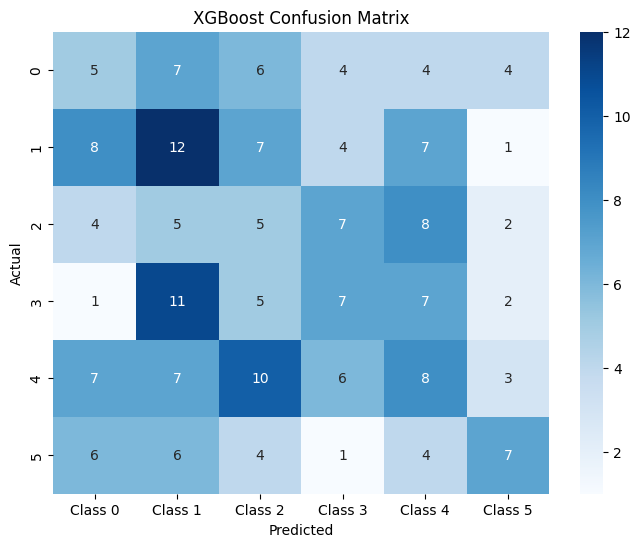

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define feature matrix (X) and target variable (y)
features = ["SMA_10", "SMA_30", "RSI", "MACD", "BB_High", "BB_Low", "ATR"]
X = df_all[features]
y = df_all["ReturnCategory"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the models
rf = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42, class_weight="balanced")

# Train the models
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)

# Print accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

# Classification report for XGBoost
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap="Blues", fmt="d", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

With Feature Importance Integrated

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 808, number of used features: 7
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Random Forest Accuracy: 0.16831683168316833
XGBoost Accuracy: 0.21782178217821782
LightGBM Accuracy: 0.19306930693069307
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.17      0.16        30
           1       0.25      0.31      0.28        39
           2       0.14      0.16      0.15        31
           3       0.24      0.21      0.23        33
           4       0.21      0.20      0.20        41
           5       0.37      0.25      0.30        28

    accuracy                           0.22       202
   macro avg       0.23      0.22      0.22       202
weighted avg       0.23      0.22      0.22       202



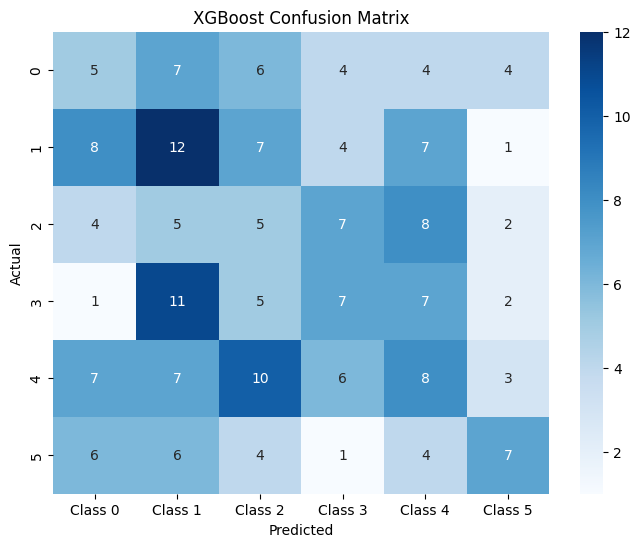

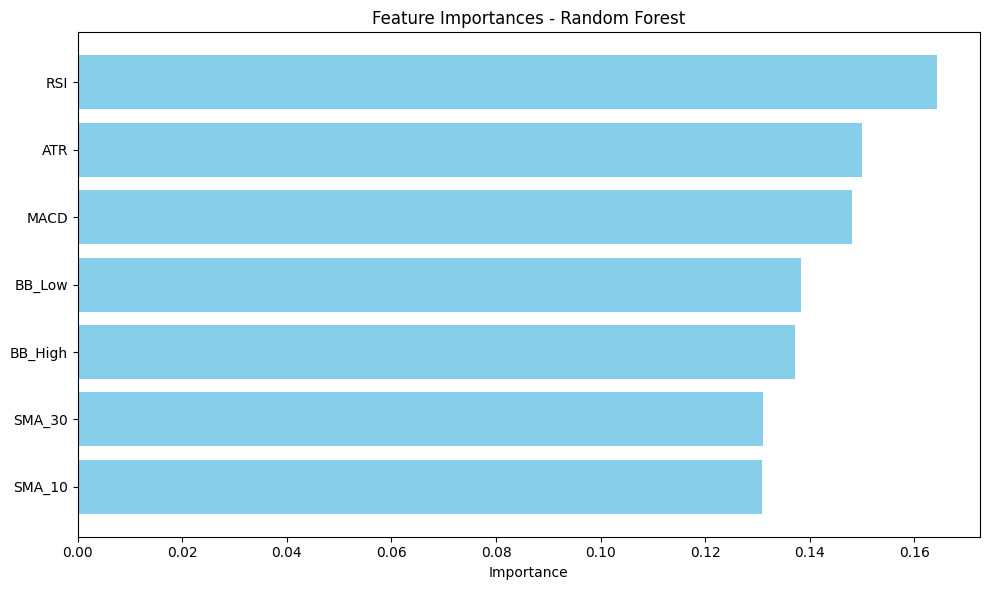

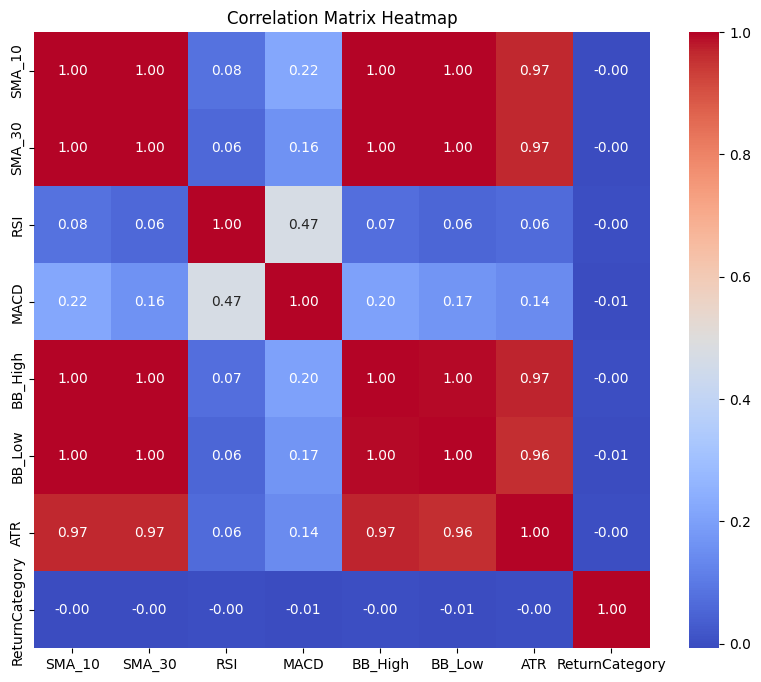

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define feature matrix (X) and target variable (y)
features = ["SMA_10", "SMA_30", "RSI", "MACD", "BB_High", "BB_Low", "ATR"]
X = df_all[features]
y = df_all["ReturnCategory"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the models
rf = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42, class_weight="balanced")

# Train the models
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)

# Print accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

# Classification report for XGBoost
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap="Blues", fmt="d",
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# ---------------------- #
# 🔍 Feature Importance (Random Forest)
# ---------------------- #
importances = rf.feature_importances_
indices = np.argsort(importances)
feature_names = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center", color="skyblue")
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ---------------------- #
# 🔍 Correlation Matrix + Heatmap
# ---------------------- #
# Create a copy of the dataframe with features + target
df_corr = df_all[features + ["ReturnCategory"]]

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


**Logistic Regression Baseline**

Logistic Regression Accuracy: 0.24257425742574257
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.45      0.34        29
           1       0.25      0.05      0.08        40
           2       0.20      0.34      0.25        32
           3       0.25      0.03      0.05        34
           4       0.32      0.35      0.33        40
           5       0.19      0.30      0.23        27

    accuracy                           0.24       202
   macro avg       0.25      0.25      0.21       202
weighted avg       0.25      0.24      0.21       202



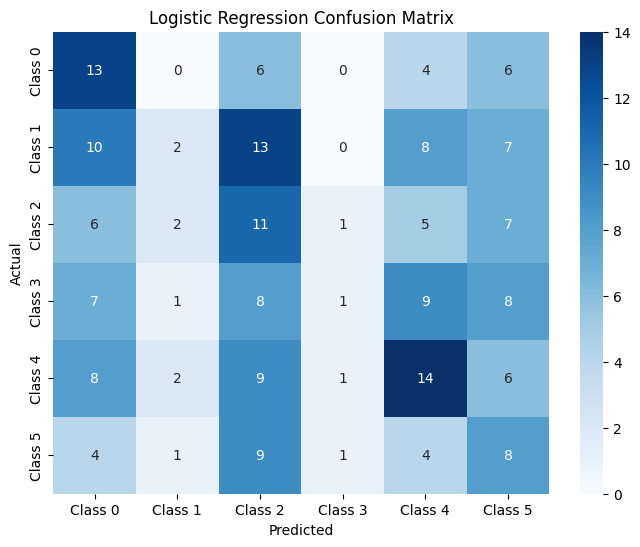

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

# Train the Logistic Regression model
log_reg.fit(X_train, y_train)

# Predict on test set using Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)

# Print accuracy for Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))

# Classification report for Logistic Regression
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# Confusion Matrix for Logistic Regression
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, cmap="Blues", fmt="d",
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()